**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import sympy as sm
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize, fixed_point, root
from scipy import interpolate
from scipy.stats import norm
%load_ext autoreload
%autoreload 2

## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $C = (1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

#### Question 1

Plan: 
I want to solve it with sympy.

1. Set parameters and define symbols
2. Define functions
3. Sub in constraint (C)
4. Calc derivative dV/dL and find FOC
5. Evaluate function for G=1 and G=2
6. Verify the solution is correct

In [2]:
sm.init_printing()

# 1a. define symbols
L, w, tau, G, kappa, alpha, nu, wtilde = sm.symbols('L w tau G kappa alpha nu wtilde')

# 1b. parameters
alpha = 0.5
kappa = 1.0
nu = 1 / (2 * 16**2)
w = 1
tau = 0.3
wtilde = 0.7

# 2. utility and consumption function
C = kappa + (1 - tau) * w * L
V = sm.ln(C**alpha * G**(1 - alpha)) - nu * L**2 / 2

# 3. substitute in budget_cons

budget_constraint = sm.Eq(C, kappa + (1-tau)*w*L)
V_cons = sm.ln((kappa + (1-tau)*w*L)**alpha * G**(1 - alpha)) - nu * L**2 / 2


# 4a. valculate derivative
Vprime = sm.diff(V_cons, L)

# 4b. find the maximum
sol = sm.solve(Vprime, L)


# 5. evaluate for G=1 and G=2
G_values = [1, 2]
sol_G = {g: [s.subs(G, g) for s in sol] for g in G_values}

print('Optimized labor hours for G=1 and G=2:')
display(sol_G)




Optimized labor hours for G=1 and G=2:


{1: [-16.730221655767, 15.3016502271956], 2: [-16.730221655767, 15.30165022719
56]}

I'm not interested in negative solutions to labor supply, so I look at the second elements:

In [3]:
# 6. verifying solution:

# i. Writing down the provided solution
Lwtilde = (-kappa + sm.sqrt(kappa**2 + 4 * (alpha / nu) * wtilde**2)) / (2 * wtilde)

# ii. checking its equal to the sympy solution
if sol_G[1][1].equals(Lwtilde):
    print(f'The expressions are equal')
else:
    print(f'The expressions are not equal')



The expressions are equal


The expression is verified as correct.

-------------

#### Question 2

1. Use definitions from Q1
2. Create array of values that w can take
3. iterate over the array and solve for optimal L
4. Plot the results against the w array

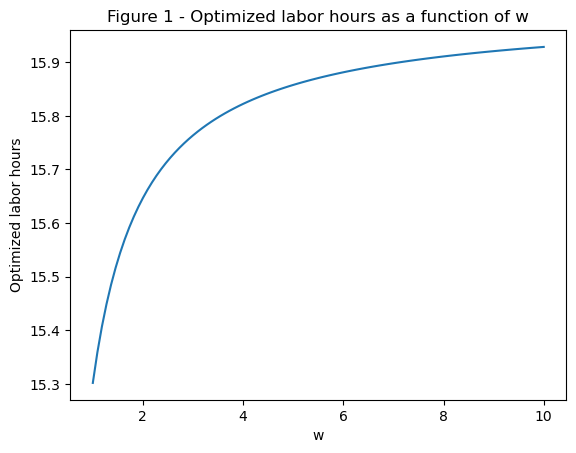

In [4]:
# define symbols
L, w, tau, G, kappa, alpha, nu, wtilde = sm.symbols('L w tau G kappa alpha nu wtilde')

# parameters
alpha_val = 0.5
kappa_val = 1.0
nu_val = 1 / (2 * 16**2)
tau_val = 0.3
wtilde_val = 0.7

# utility function
C = kappa + (1 - tau) * w * L
V = sm.ln(C**alpha * G**(1 - alpha)) - nu * L**2 / 2

# substitute in budget constraint
budget_constraint = sm.Eq(C, kappa + (1-tau)*w*L)
V_cons = sm.ln((kappa + (1-tau)*w*L)**alpha * G**(1 - alpha)) - nu * L**2 / 2

# calculate derivative
Vprime = sm.diff(V_cons, L)

# find the maximum
sol1 = sm.solve(Vprime, L)

# 2. w array
w_values = np.linspace(1, 10, 100)  

results= []
# 3. vary w and evaluate
for w_val in w_values:
    sol_G1 = [s.subs({alpha: alpha_val, kappa: kappa_val, nu: nu_val, w: w_val, tau: tau_val}) for s in sol1]
    results.append(sol_G1[0])  # assuming there's only one solution

# 4. plot the results

plt.plot(w_values, results)

plt.xlabel('w')
plt.ylabel('Optimized labor hours')
plt.title('Figure 1 - Optimized labor hours as a function of w')
plt.show()

Optimal labor supply is a concave function of w, implying diminishing utility returns

--------------


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


Plan:

This looks like a complex problem with an implicitly defined L, so I rethink my approach from symbolic to explicitly numeric. 

I'm interpreting the $L^{\star}$ in the assignment text to be as a function of $((1-\tau)w)$ rather than multiplied with it. 

1. Set parameters
2. Define functions but this time not via sympy
3. Find a method that can handle functions involving variables implicitly defined (fixed-point iteration)
4. Test optimization
5. Let $\tau$ vary
6. Plot the results

In [5]:
# setting up and testing 
# 1. parameters
alpha = 0.5
kappa = 1.0
nu = 1 / (2 * 16**2)
w = 1
tau = 0.3

# 2. define functions

def utility(L, L_star, alpha, kappa, nu, w, tau):
    '''Worker Utility function 
    args; L: Labor, L_star: optimal labor, Model parameters'''
    C = kappa + (1 - tau) * w * L
    G = tau * w * L_star 
    V = np.log(C**alpha * G**(1 - alpha)) - nu * L**2 / 2
    return -V  


def G_func(L_star):
    '''Optimizer used to find optimal labor'''
    L_start = L_star # initial value
    res = minimize(utility, L_start, args=(L_star, alpha, kappa, nu, w, tau), method='Nelder-Mead')
    return res.x[0]


L_star_start = 0.5 # initial guess for L_star

# 3./4. find fixed point func(x0)==x0
L_star = fixed_point(G_func, L_star_start, method="iteration")
print(f"The solution to the maximization problem is L* = {L_star}")

The solution to the maximization problem is L* = 15.30166015625003


The solution is the same as before, which is not catastrophic, but I have no real intuition as to whether it is correct, so I soldier on. 

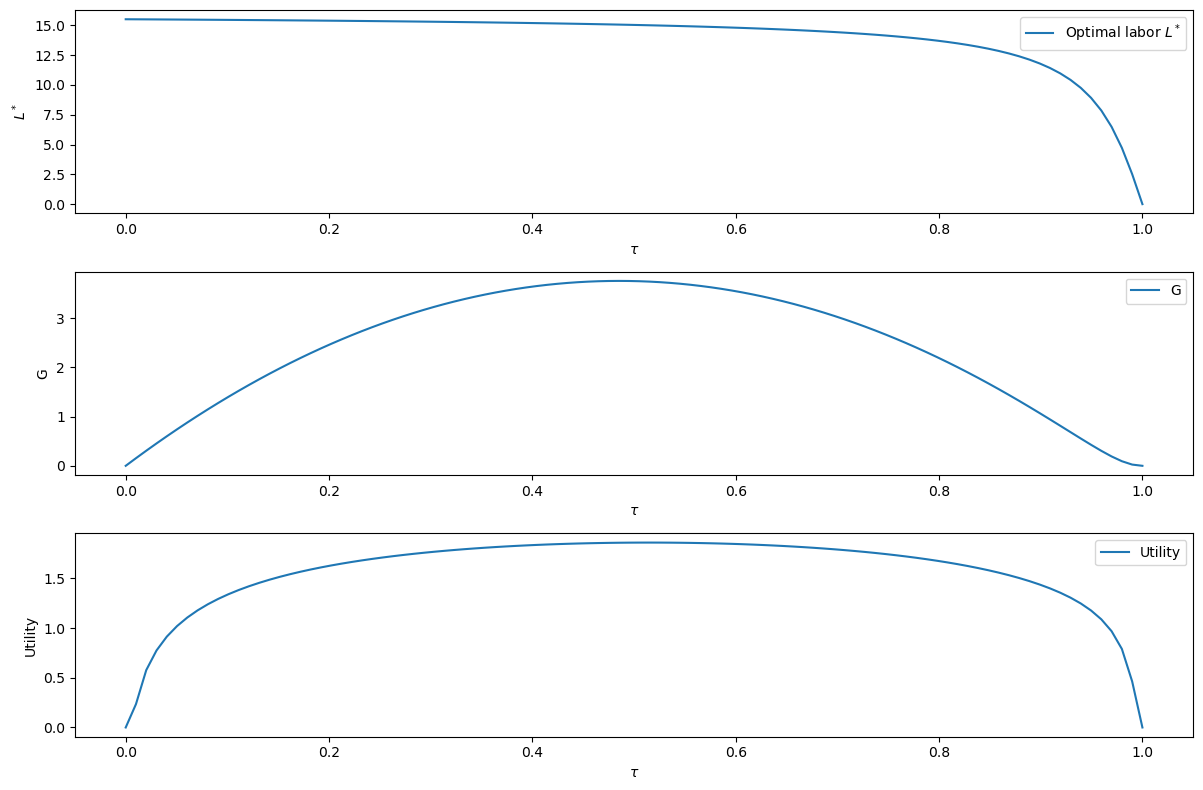

In [6]:
# parameters
alpha = 0.5
kappa = 1.0
nu = 1 / (2 * 16**2)
w = 1

# 2. define functions

# 2a. new utility function cuz the old had some issues with warnings due to division by zero
def utility(L, L_star, alpha, kappa, nu, w, tau):
    C = kappa + (1 - tau) * w * L
    G = tau * w * L_star
   
    V = np.log(np.maximum(G, 1e-10)**(1 - alpha) * C**alpha) - nu * L**2 / 2
    return -V

# 2b. new G-func to accomodate tau
def G_func(L_star, tau):
    L_start = L_star
    res = minimize(utility, L_start, args=(L_star, alpha, kappa, nu, w, tau), method='Nelder-Mead')
    return res.x[0]


tau_values = np.linspace(0, 1, 100) # generate a grid of tau values

# initialize arrays to store the results
L_star_values = np.empty_like(tau_values)
G_values = np.empty_like(tau_values)
utility_values = np.empty_like(tau_values)

# 5. for each tau, solve for L_star and calculate G and utility
for i, tau in enumerate(tau_values):
    # i. find the optimal labor
    L_star = fixed_point(G_func, 0.5, args=(tau,), method="iteration")
    
    # ii. compute G
    G = tau * w * L_star * ((1 - tau) * w)
    
    # iii. compute the utility
    U = -utility(L_star, L_star, alpha, kappa, nu, w, tau) 
    
    # iv. store the results
    L_star_values[i] = L_star
    G_values[i] = G
    utility_values[i] = U


utility_values = np.maximum(utility_values, 0) # force utility values to be zero or above


# 6. create the plots
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(tau_values, L_star_values, label="Optimal labor $L^*$")
plt.xlabel("$\\tau$")
plt.ylabel("$L^*$")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(tau_values, G_values, label="G")
plt.xlabel("$\\tau$")
plt.ylabel("G")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(tau_values, utility_values, label="Utility")
plt.xlabel("$\\tau$")
plt.ylabel("Utility")
plt.legend()

plt.tight_layout()
plt.show()

These results look in line with what could be expected. Labor is concave with diminishing returns due to disutility to labor. 

Government consumption looks like the Laffer-curve, also as expected. 

The model is Cobb-Douglas, so marginal utility is very high in the margins. 

--------------------------------

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

1. Set parameters, define func.
2. Reuse fixed-point optimizer
3. Instead of iterating tau, write function that optimizes tau based on the FP and utility
4. Optimize

In [7]:

# 1. parameters
alpha = 0.5
kappa = 1.0
nu = 1 / (2 * 16**2)
w = 1

# 2. functions
def utility(L, L_star, alpha, kappa, nu, w, tau):
    C = kappa + (1 - tau) * w * L
    G = tau * w * L_star 
    if G <= 0:  # check if G is less than or equal to zero
        return -np.inf  # return a very large negative utility
    else:
        V = np.log(np.maximum(G, 1e-10)**(1 - alpha) * C**alpha) - nu * L**2 / 2
        return -V


def G_func(L_star, tau):
    L_start = L_star
    res = minimize(utility, L_start, args=(L_star, alpha, kappa, nu, w, tau), method='Nelder-Mead')
    return res.x[0]

# 3. define function to find the maximum utility for a given tau
def utility_max(tau):
    # i. find the optimal labor by fixed-point (2.)
    L_star = fixed_point(G_func, 0.5, args=(tau,), method="iteration")
    
    # ii. compute the utility
    U = -utility(L_star, L_star, alpha, kappa, nu, w, tau)  
    
    return -U  


tau_start = 0.1 # initial guess for tau

# 4. find the tau that maximizes utility
rest = minimize(utility_max, tau_start, bounds=[(0, 1)], method='Nelder-Mead')
tau_star = rest.x[0]

print(f"The value of tau that maximizes utility is tau* = {tau_star}")

The value of tau that maximizes utility is tau* = 0.5145312500000015


Looks like my tax rate, which I don't find optimal. :)

---------------

A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{\sigma-1} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

Plan: 

For both sets of parameters; 
1. Set Parameters
2. Define new utility function
3. Solve max. problem dutility/dL for given values of G and tau
4. Define function that solves for G with L_star as input
5. Solve it

In [8]:
# A. FIRST SET
# 1. parameters
alpha = 0.5
kappa = 1.0
nu = 1 / (2 * 16**2)
w = 1
rho = 1.001
sigma = 1.001
epsilon = 1.0

# 2. utility function
def utility(L, tau, G, w, alpha, kappa, nu, rho, sigma, epsilon):
    
    C = kappa + (1 - tau) * w * L
    term1 = alpha * (C**((sigma - 1) / sigma)) 
    term2 = (1 - alpha) * (G**((sigma - 1) / sigma))
    utility = ((term1 + term2)**(sigma / (sigma - 1)))**(1 - rho) / (1 - rho) - nu * L**(1 + epsilon) / (1 + epsilon)
    return -utility  

# 3. solving the maximization problem for given tau and G
def solve_worker(tau, G):
    res = minimize(utility, 0.5, args=(tau, G, w, alpha, kappa, nu, rho, sigma, epsilon), method = 'Nelder-Mead')
    L_star = res.x[0]
    return L_star

In [9]:
# 4. equilibrium condition
def equilibrium(G, tau):
    L_star = solve_worker(tau, G)
    return G - tau * w * L_star

# 5. finding the equilibrium G
rest2 = root(equilibrium, 2, args=(tau_star)) 
G_star = rest2.x[0]

print(f"The value of G that solves the first set equilibrium condition is G* = {G_star}")

L_staropt = solve_worker(tau_star, G_star)

print(f"The optimal labor supply for the equilibrium G* is L* = {L_staropt}")

Copt = kappa + (1-tau_star) * w * L_staropt 

print(f"The optimal consumption for the equilibrium G* is C = {Copt}")

GCrel = G_star/Copt

print(f"G/C = {GCrel}")

The value of G that solves the first set equilibrium condition is G* = 7.711235626220742
The optimal labor supply for the equilibrium G* is L* = 14.98691406250003
The optimal consumption for the equilibrium G* is C = 8.27567843627929
G/C = 0.9317949803868505


This looks like it could be true.

In [10]:
# B. SECOND SET
# "I apologize for writing such long code, I don't have time to make it shorter" - Goethe the hacker
# 1. parameters
alpha = 0.5
kappa = 1.0
nu = 1 / (2 * 16**2)
w = 1
rho = 1.5
sigma = 1.5
epsilon = 1.0

# 2. utility function
def utility(L, tau, G, w, alpha, kappa, nu, rho, sigma, epsilon):
 
    C = kappa + (1 - tau) * w * L
    term1 = alpha * (C**((sigma - 1) / sigma))
    term2 = (1 - alpha) * (G**((sigma - 1) / sigma))
    utility = ((term1 + term2)**(sigma / (sigma - 1)))**(1 - rho) / (1 - rho) - nu * L**(1 + epsilon) / (1 + epsilon)
    return -utility  

# 3. solving the maximization problem for given tau and G
def solve_worker(tau, G):
    res = minimize(utility, 0.5, args=(tau, G, w, alpha, kappa, nu, rho, sigma, epsilon), method = 'Nelder-Mead')
    L_star = res.x[0]
    return L_star

In [11]:
 # 4 .equilibrium condition
def equilibrium(G, tau):
    L_star = solve_worker(tau, G)
    return G - tau * w * L_star 

# 5. finding the equilibrium G and derived results
rest3 = root(equilibrium, 0.5, args=(tau_star))  
G_star = rest3.x[0]
L_staropt = solve_worker(tau_star, G_star)
Copt = kappa + (1-tau_star) * w * L_staropt 
GCrel = G_star/Copt


print(f"The value of G that solves the second set equilibrium condition is G* = {G_star}")
print(f"The optimal labor supply for the equilibrium G* is L* = {L_staropt}")
print(f"The optimal consumption for the equilibrium G* is C = {Copt}")
print(f"G/C = {GCrel}")

The value of G that solves the second set equilibrium condition is G* = 4.975225753784205
The optimal labor supply for the equilibrium G* is L* = 9.66943359375002
The optimal consumption for the equilibrium G* is C = 5.694207839965815
G/C = 0.8737344848680609


Government consumption is lower for higher $\sigma$ and higher $\rho$. This makes sense, because $\rho$ describes the marginal utility of consumption, so higher $\rho$ would imply less utility overall and thus lower G. $\sigma$ is the elasticity of substitution between private and government consumption. Since it is higher, consumers can more easily substitute away from government consumption, thus the share of government consumption has dropped relative to private. 

--------------

**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

Plan:

1. Copy the code from above
2. Define a utility function that incorporates the G solution and takes tau as argument
3. Maximize it

In [12]:
# A. FIRST SET 
# parameters

alpha = 0.5
kappa = 1.0
nu = 1 / (2 * 16**2)
w = 1
rho = 1.001
sigma = 1.001
epsilon = 1.0

def utility(L, tau, G, w, alpha, kappa, nu, rho, sigma, epsilon):
    if G < 0:  # check if G is negative
        return 1e10  # return a large positive number
    C = kappa + (1 - tau) * w * L
    term1 = alpha * (C**((sigma - 1) / sigma)) 
    term2 = (1 - alpha) * (G**((sigma - 1) / sigma))
    # Check if the expression inside the power operation is negative
    if term1 < 0 or term2 < 0:
        return 1e10
    utility = ((term1 + term2)**(sigma / (sigma - 1)))**(1 - rho) / (1 - rho) - nu * L**(1 + epsilon) / (1 + epsilon)
    return -utility

# 6. socially optimal tau
def social_optimum(tau, w, alpha, kappa, nu, rho, sigma, epsilon):
    # first solve for G using the equilibrium condition
    res = root(equilibrium, 0.5, args=(tau,)) # we start with an initial guess of 0.5 for G
    G_star = res.x[0]
    # then compute optimal labor supply given tau and G_star
    L_star = solve_worker(tau, G_star)
    # finally, compute utility at optimal labor supply and G_star
    u = utility(L_star, tau, G_star, w, alpha, kappa, nu, rho, sigma, epsilon)
    # we want to maximize utility, so we return negative utility as our objective function
    return u 

# use an optimization algorithm to find tau_star
rest99 = minimize(social_optimum, 0.5, args=(w, alpha, kappa, nu, rho, sigma, epsilon), bounds=[(0, 1)], method='L-BFGS-B')
tau_star1 = rest99.x[0]


print(f"The socially optimal tax rate is τ* = {tau_star1}")


The socially optimal tax rate is τ* = 0.516677928403511


In [13]:
# A. SECOND SET 

# parameters
alpha = 0.5
kappa = 1.0
nu = 1 / (2 * 16**2)
w = 1
rho = 1.5
sigma = 1.5
epsilon = 1.0

def utility(L, tau, G, w, alpha, kappa, nu, rho, sigma, epsilon):
    
    C = kappa + (1 - tau) * w * L
    term1 = alpha * (C**((sigma - 1) / sigma)) 
    term2 = (1 - alpha) * (G**((sigma - 1) / sigma))
    # Check if the expression inside the power operation is negative
    if term1 < 0 or term2 < 0:
        return 1e10
    utility = ((term1 + term2)**(sigma / (sigma - 1)))**(1 - rho) / (1 - rho) - nu * L**(1 + epsilon) / (1 + epsilon)
    return -utility

# 2. socially optimal tau
def social_optimum(tau, w, alpha, kappa, nu, rho, sigma, epsilon):
    # first solve for G using the equilibrium condition
    res = root(equilibrium, 0.5, args=(tau,)) # we start with an initial guess of 0.5 for G
    G_star = res.x[0]
    # then compute optimal labor supply given tau and G_star
    L_star = solve_worker(tau, G_star)
    # finally, compute utility at optimal labor supply and G_star
    u = utility(L_star, tau, G_star, w, alpha, kappa, nu, rho, sigma, epsilon)
    # we want to maximize utility, so we return negative utility as our objective function
    return u 

# 3. optimize to find tau 
rest6 = minimize(social_optimum, 0.5, args=(w, alpha, kappa, nu, rho, sigma, epsilon), bounds=[(0, 1)], method='L-BFGS-B')
tau_star2 = rest6.x[0]


print(f"The socially optimal tax rate is τ* = {tau_star2}")


The socially optimal tax rate is τ* = 0.46633303380070606


The tax rate is lower for higher sigma and rho, which makes sense because higher elasticity of subtitution means higher incentive to substitute from G to C, which means a lower tax becomes optimal all else equal. Higher rho means less marginal utility from work, the effect of which im unsure.

## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each hairdresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

1. Set parameters and define profit
2. Optimize for each kappa
3. Verify solution

In [14]:
# 1. set parameters
eta = 0.5
w = 1.0
kappa_values = [1,2]

# 1. define profit function

def profit(l, kappa):
    
    return -(kappa * l**0.5 - w * l)


sol_l = {}
# 2. iterate over kappa_values, calculate the optimal number of hairdressers and store in the dictionary
for kappa in kappa_values:
    result = minimize(profit, x0=[1], args=(kappa,), bounds=[(0, None)], method='Nelder-Mead')

    
    # i. store optimal l in dictionary
    sol_l[kappa] = result.x[0]

# print the solutions
for kappa, opt_l in sol_l.items():
    print("The optimal number of hairdressers for demand shock", kappa, "is", opt_l)

The optimal number of hairdressers for demand shock 1 is 0.24999999999999933
The optimal number of hairdressers for demand shock 2 is 1.0


In [15]:
# 3. verifying 

epsilon = 1e-7 #verifying the results to within a certain tolerance, cuz it certainly looks like the answer is 0.25

# the expression to check, with kappa=1
l_t_1 = (((1-eta)*1)/w)**(1/eta)  

if abs(sol_l[1]-l_t_1) < epsilon: # the optimized l, kappa = 1 
    print(f'The expressions are equal')
else:
    print(f'The expressions are not equal')

l_t_2 = (((1-eta)*2)/w)**(1/eta) # expression to check, kappa = 2

if abs(sol_l[2]-l_t_2) < epsilon:
    print(f'The expressions are equal')
else:
    print(f'The expressions are not equal')

The expressions are equal
The expressions are equal


The expression has been verified numerically.

--------------

We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K-1} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

Plan:
1. Set Parameters
2. Define profit and policy function
3. Generate random shock series $\kappa$
4. Create for-loop over t calculating the output of policy and profit $h$ for each $\kappa$ 
5. Create for-loop over $K$ for each $\kappa$, outputting $H$, the mean of the $h$'s
6. Create for-loop for different values of $K$, outputting a list of $H$
7. Plot $H$ as a function of $K$
8. Calculate the mean of $H$ for a good set of $K$ 

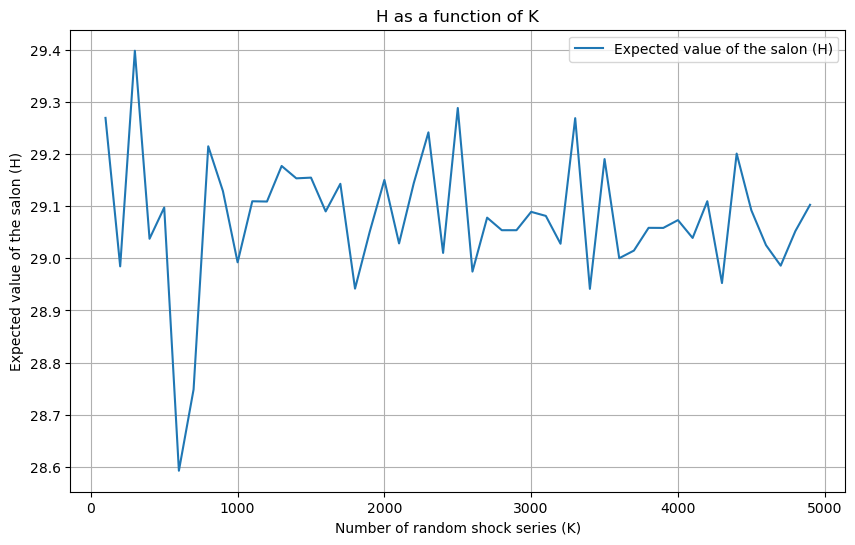

In [16]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# 1. parameters
rho = 0.90
iota = 0.01
sigma_epsilon = 0.10
R = (1+0.01)**(1/12)
eta = 0.5
w = 1.0
T = 120  # number of months

# 2.a function to calculate profits given kappa and l
def calculate_profits(kappa, l, prev_l):
    return R * (kappa * l**(1 - eta) - w * l - iota * (l != prev_l))

# 2.b function to calculate l given kappa
def calculate_l(kappa):
    return ((1 - eta) * kappa / w) ** (1 / eta)


H_values = [] # initialize list to store H for different K

# 5. K for-loop
K_values = range(100, 5000, 100)
for K in K_values:
    # initialize profits
    profits = np.zeros(K)

    # 5. loop over K random shock series
    for k in range(K):
        # initialize kappa and l
        kappa = np.ones(T + 1)  # plus 1 because kappa starts from t = -1
        l = np.zeros(T + 1)  

        # 3. generate random shock series
        epsilon = norm.rvs(loc=-0.5 * sigma_epsilon**2, scale=sigma_epsilon, size=T)

        # 4.a update kappa and l for each month
        for t in range(T):
            kappa[t + 1] = np.exp(rho * np.log(kappa[t]) + epsilon[t])
            l[t + 1] = calculate_l(kappa[t + 1])

        # 4.b calculate profits for this shock series and add to total profits
        for t in range(T):
            profits[k] += calculate_profits(kappa[t + 1], l[t + 1], l[t])

    # calculate and append H to H_values
    H = np.mean(profits)
    H_values.append(H)

# 6. plot H as a function of K
plt.figure(figsize=(10, 6))
plt.plot(K_values, H_values, label='Expected value of the salon (H)')
plt.xlabel('Number of random shock series (K)')
plt.ylabel('Expected value of the salon (H)')
plt.title('H as a function of K')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# 7. calculate and print the mean of H for an appropriate set of K
mean_H_for_K_greater_than_2000 = np.mean(H_values[20:])

print("The mean value of H for K > 2000 shocks is", mean_H_for_K_greater_than_2000)

The mean value of H for K > 2000 shocks is 29.077397789228556


------------------------------

Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

1. Copy from Q2 above
2. Include new delta
3. Alter the t-loop to incorporate new policy
4. Same procedure as Q2

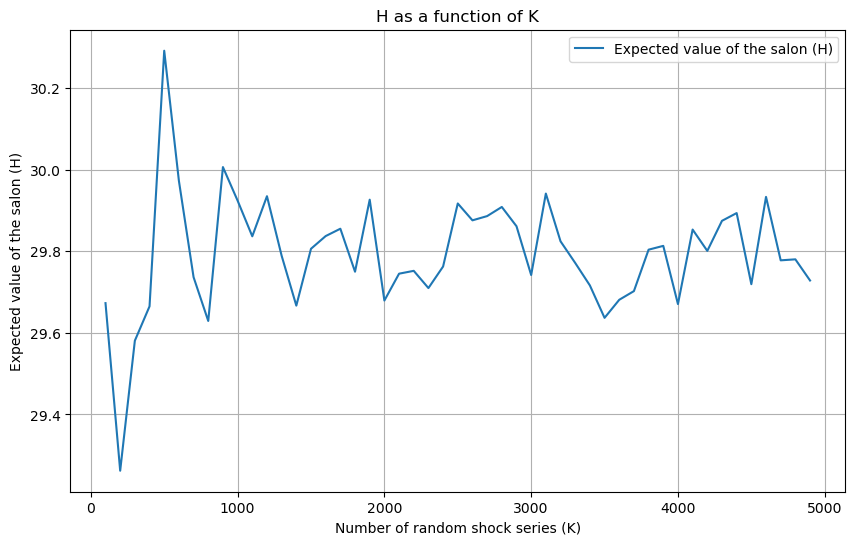

In [18]:

# parameters
rho = 0.90
iota = 0.01
sigma_epsilon = 0.10
R = (1+0.01)**(1/12)
eta = 0.5
w = 1.0
T = 120  # mumber of months
Delta = 0.05 # 2. delta

# function to calculate profits given kappa and l
def calculate_profits(kappa, l, prev_l):
    return R * (kappa * l**(1 - eta) - w * l - iota * (l != prev_l))

# function to calculate l given kappa
def calculate_l(kappa):
    return ((1 - eta) * kappa / w) ** (1 / eta)

# initialize list to store H for different K
H1_values = []

K_values = range(100, 5000, 100)
for K in K_values:
    # initialize profits
    profits = np.zeros(K)

    # loop over K random shock series
    for k in range(K):
        # initialize kappa and l
        kappa = np.ones(T + 1)  # plus 1 because kappa starts from t = -1
        l = np.zeros(T + 1)  

        # generate random shock series
        epsilon = norm.rvs(loc=-0.5 * sigma_epsilon**2, scale=sigma_epsilon, size=T)

        # update kappa and l for each month
        for t in range(T):
            kappa[t + 1] = np.exp(rho * np.log(kappa[t]) + epsilon[t])
            l_star = calculate_l(kappa[t + 1])
            # 3. update l according to the new policy
            if abs(l[t] - l_star) > Delta:
                l[t + 1] = l_star
            else:
                l[t + 1] = l[t]

        # calculate profits for this shock series and add to total profits
        for t in range(T):
            profits[k] += calculate_profits(kappa[t + 1], l[t + 1], l[t])

    # calculate and append H to H_values
    H = np.mean(profits)
    H1_values.append(H)


# plot H as a function of K
plt.figure(figsize=(10, 6))
plt.plot(K_values, H1_values, label='Expected value of the salon (H)')
plt.xlabel('Number of random shock series (K)')
plt.ylabel('Expected value of the salon (H)')
plt.title('H as a function of K')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# calculate and print the mean of H for an appropriate set of K
mean_H1_for_K_greater_than_2000 = np.mean(H1_values[20:])

print("The mean value of H_1 for K > 2000 shocks is", mean_H1_for_K_greater_than_2000)

The mean value of H_1 for K > 2000 shocks is 29.796015875614717


The profitability of the salon has improved, as its ex ante estimated value is now higher. This is because the new policy function take into account the existence of the adjustment cost $\iota$, leading to improved optimization of profits. 

--------------

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

1. Copy from Q3
2. Create array of $\Delta$
3. Replace the K_value loop used for plotting with a $\Delta$ loop to optimize over 
4. Find the optimal $\Delta$ and print it
5. Plot H against $\Delta$ 

The optimal value of Delta that maximizes H is 0.17171717171717174.
The maximum value of H is 29.93842954601125.


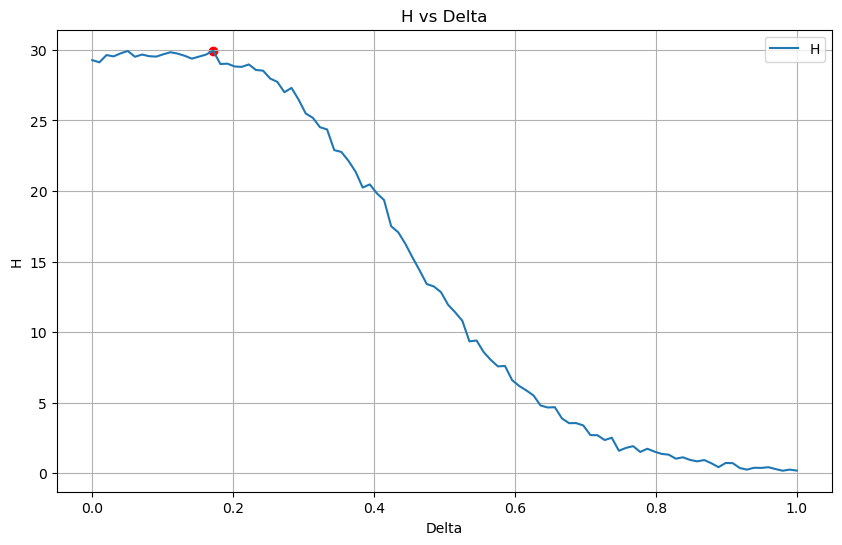

In [20]:
# parameters
rho = 0.90
iota = 0.01
sigma_epsilon = 0.10
R = (1+0.01)**(1/12)
eta = 0.5
w = 1.0
K = 1000  
T = 120  

# function to calculate profits given kappa and l
def calculate_profits(kappa, l, prev_l):
    return R * (kappa * l**(1 - eta) - w * l - iota * (l != prev_l))

# function to calculate l given kappa
def calculate_l(kappa):
    return ((1 - eta) * kappa / w) ** (1 / eta)

# 2. set up an array of potential Delta values
Delta_values = np.linspace(0, 1, 100)

# initialize a new list to store H for each Delta
H_values3 = []

# 3. loop over Delta values
for Delta in Delta_values:
    # initialize profits
    profits = np.zeros(K)

    # loop over K random shock series
    for k in range(K):
        # initialize kappa and l
        kappa = np.ones(T + 1)  
        l = np.zeros(T + 1) 

        # generate random shock series
        epsilon = norm.rvs(loc=-0.5 * sigma_epsilon**2, scale=sigma_epsilon, size=T)

        # update kappa and l for each month
        for t in range(T):
            kappa[t + 1] = np.exp(rho * np.log(kappa[t]) + epsilon[t])
            l_star = calculate_l(kappa[t + 1])
            # update l according to the policy
            if abs(l[t] - l_star) > Delta:
                l[t + 1] = l_star
            else:
                l[t + 1] = l[t]

        # calculate profits for this shock series and add to total profits
        for t in range(T):
            profits[k] += calculate_profits(kappa[t + 1], l[t + 1], l[t])

    # calculate and store H for this Delta
    H = np.mean(profits)
    H_values3.append(H)

# 4a. find Delta that maximizes H
optimal_Delta = Delta_values[np.argmax(H_values3)]

# 4b. print the optimal Delta
print(f'The optimal value of Delta that maximizes H is {optimal_Delta}.')
print(f'The maximum value of H is {max(H_values3)}.')
# 5. plot H against Delta
plt.figure(figsize=(10,6))
plt.plot(Delta_values, H_values3, label='H')
plt.scatter(optimal_Delta, max(H_values3), color='red')  # mark the optimal Delta
plt.xlabel('Delta')
plt.ylabel('H')
plt.title('H vs Delta')
plt.legend()
plt.grid(True)
plt.show()

Since $\Delta$ represents how responsive the salon is to changes in the number of optimal hairdressers, it's clear that for $\Delta$ $\rightarrow \infty $ profit will plummet, as there is no optimization. The higher $\iota$ is, the higher the cost of changing the number of hairdressers, and therefore the higher the optimal $\Delta$ should become.  

---------------


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



I try implementing a policy that adjusts $\ell$ only if the expected profit from doing so exceeds the $\iota$ cost. 

1. Copy from Q4
2. Adjust the t loop to calculate expected profits
3. Implement new $\ell$ only if expected profits are greater than $\iota$

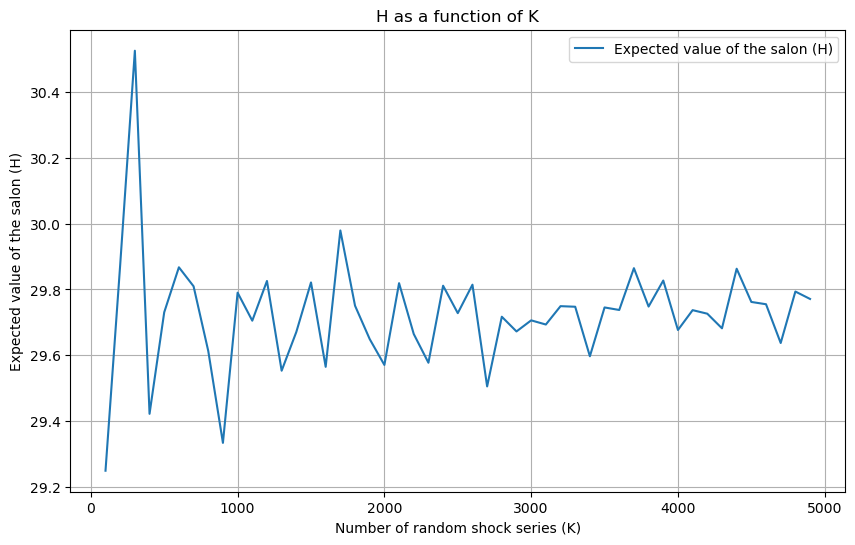

In [21]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# parameters
rho = 0.90
iota = 0.01
sigma_epsilon = 0.10
R = (1+0.01)**(1/12)
eta = 0.5
w = 1.0
T = 120  
K_values = np.arange(100, 5000, 100)  

# function to calculate profits given kappa and l
def calculate_profits(kappa, l, prev_l):
    return R * (kappa * l**(1 - eta) - w * l - iota * (l != prev_l))

# function to calculate l given kappa
def calculate_l(kappa):
    return ((1 - eta) * kappa / w) ** (1 / eta)

# initialize new H list
Hi_values = []

# loop over different K values
for K in K_values:
    profits = np.zeros(K)

    # loop over K random shock series
    for k in range(K):
        # initialize kappa and l
        kappa = np.ones(T + 1)  # Plus 1 because kappa starts from t = -1
        l = np.zeros(T + 1)  # Plus 1 because l starts from t = -1

        # generate random shock series
        epsilon = norm.rvs(loc=-0.5 * sigma_epsilon**2, scale=sigma_epsilon, size=T)

       # 2. update kappa and l for each month
        for t in range(T):
           kappa[t + 1] = np.exp(rho * np.log(kappa[t]) + epsilon[t])
           l_star = calculate_l(kappa[t + 1])
           current_profit = calculate_profits(kappa[t + 1], l[t], l[t-1])
           optimal_profit = calculate_profits(kappa[t + 1], l_star, l[t])
           profit_diff = optimal_profit - current_profit

            # 3. update l if profit gain from adjusting l exceeds iota
           if profit_diff > iota:
               l[t + 1] = l_star
           else:
               l[t + 1] = l[t]

        # calculate profits for this shock series and add to total profits
        for t in range(T):
            profits[k] += calculate_profits(kappa[t + 1], l[t + 1], l[t])

    # calculate and append H to Hi_values
    H = np.mean(profits)
    Hi_values.append(H)

# plot H as a function of K
plt.figure(figsize=(10, 6))
plt.plot(K_values, Hi_values, label='Expected value of the salon (H)')
plt.xlabel('Number of random shock series (K)')
plt.ylabel('Expected value of the salon (H)')
plt.title('H as a function of K')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# calculate and print the mean of H for an appropriate set of K
mean_Hi_for_K_greater_than_2000 = np.mean(Hi_values[20:])

print("The mean value of H for K > 2000 shocks is", mean_Hi_for_K_greater_than_2000)

The mean value of H for K > 2000 shocks is 29.72877314091492


The policy does not seem to be an improvement on the delta-policy. I apologize to the shareholders. 

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [23]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

Iteration 0: Initial guess is [110.25486683  93.38498558] with function value 5.1951250519040455
Iteration 1: Initial guess is [-301.75881494  547.69360877] with function value 98.52790416698534
Iteration 2: Initial guess is [160.06713104 582.43477483] with function value 91.01447161467411
Iteration 3: Initial guess is [-93.54368839 276.57618346] with function value 21.1698981636486
Iteration 4: Initial guess is [-446.90783392  429.72202867] with function value 95.15979263272953
Iteration 5: Initial guess is [-341.51353612 -510.32276888] with function value 94.49624405039867
Iteration 6: Initial guess is [496.35042128 426.76344503] with function value 106.99702471248278
Iteration 7: Initial guess is [-476.83988704  513.07736057] with function value 123.31159351453826
Iteration 8: Initial guess is [ -50.14882261 -573.79880974] with function value 82.59168835665122
Iteration 9: Initial guess is [-271.26187831 -192.42780322] with function value 27.78164378848714
Iteration 10: Initial gues

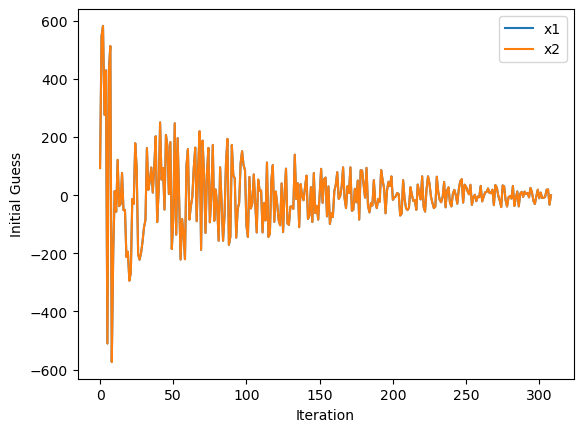

In [24]:
# chi^k function (C.)
def chi(k, K_warmup):
    return 0.50 * (2 / (1 + np.exp((k - K_warmup) / 100)))

def global_optimizer(func, bounds, K_warmup, K_max, tolerance):
    x_star = np.zeros(len(bounds)) # Zero vector
    min_func_value = np.inf  # Set to infinity initially for comparison
    initial_guesses = [] 
    for k in range(K_max): # for-loop running for K_max iterations
        x_k = np.random.uniform(bounds[:, 0], bounds[:, 1]) # Draw random guess (A.)
        if k >= K_warmup: 
            x_k0 = chi(k, K_warmup) * x_k + (1 - chi(k, K_warmup)) * x_star # I am mystified (D.) 
        else:
            x_k0 = x_k # (B.)
        initial_guesses.append(x_k0) # Append x_k0 to initial guesses lsit
        result = minimize(func, x_k0, method='BFGS', tol=tolerance) # Optimize (E.)
        if k < 10 or result.fun < min_func_value:  # Print for first 10 iterations or if the result is improved
            print(f'Iteration {k}: Initial guess is {x_k0} with function value {result.fun}')
        if result.fun < min_func_value:  # Keep track of the minimum function value found so far (F.)
            min_func_value = result.fun
            x_star = result.x
        if func(x_star) < tolerance: # Stop The Count! (G.)
            break
    return x_star, initial_guesses # 4.

# Defining bounds, tolerances and iterations
bounds = np.array([[-600, 600], [-600, 600]])
tolerance = 1e-8
K_warmup = 10
K_max = 1000

# Executing the global optimizer
x_star, initial_guesses = global_optimizer(griewank, bounds, K_warmup, K_max, tolerance)

# Visualizing how the initial guesses evolve
initial_guesses = np.array(initial_guesses)
plt.plot(initial_guesses[:, 1], label='x1')
plt.plot(initial_guesses[:, 1], label='x2')
plt.xlabel('Iteration')
plt.ylabel('Initial Guess')
plt.legend()
plt.show()

-----------

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

Iteration 0: Initial guess is [-360.90755722 -475.9866244 ] with function value 89.05555208834518
Iteration 1: Initial guess is [ 192.14690999 -280.99641022] with function value 28.74311346988813
Iteration 2: Initial guess is [563.71715474 259.13526608] with function value 96.48689144929355
Iteration 3: Initial guess is [-117.04309487  554.96621131] with function value 80.40425529319644
Iteration 4: Initial guess is [-235.20974831 -505.95671661] with function value 77.57215434707074
Iteration 5: Initial guess is [ 221.12077305 -432.00752139] with function value 58.816434093456195
Iteration 6: Initial guess is [-132.07428979   31.6011824 ] with function value 4.665830716511696
Iteration 7: Initial guess is [-587.35987735  102.54100129] with function value 88.84689215878745
Iteration 8: Initial guess is [-517.83032337  -19.39955681] with function value 67.26447515881519
Iteration 9: Initial guess is [135.00282739 483.63799589] with function value 63.131018264186466
Iteration 46: Initial 

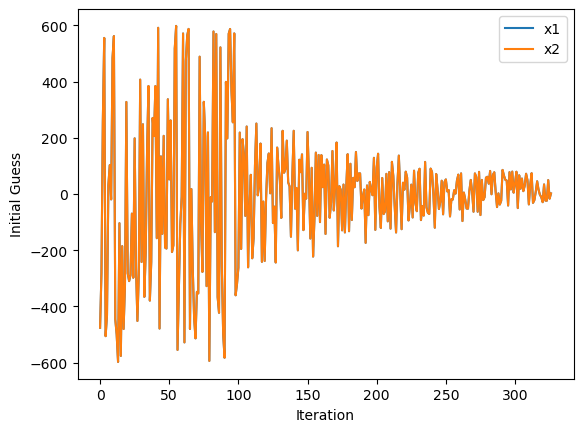

In [25]:
K_warmup2 = 100
x_star, initial_guesses = global_optimizer(griewank, bounds, K_warmup2, K_max, tolerance)

initial_guesses = np.array(initial_guesses)
plt.plot(initial_guesses[:, 1], label='x1')
plt.plot(initial_guesses[:, 1], label='x2')
plt.xlabel('Iteration')
plt.ylabel('Initial Guess')
plt.legend()
plt.show()

The convergence is slower with a higher warm-up of K. The mystical Chi-oracle is doing a good job of narrowing down the convergence.